# K-Means Clustering

### Authors

| Name | Roll Number |
|-|-|
| Gautam Singh | CS21BTECH11018 |
| Jaswanth Beere | BM21BTECH11007 |

This `.ipynb` notebook performs K-Means Clustering and analyses the impact of
preprocessing data using Principal Component Analysis (PCA) on the SVHN dataset.

## Obtaining the Data

The SVHN dataset is obtained using the `curl` command on the appropriate file
URL.

In [2]:
%%bash

if [ ! -f train_32x32.mat ]; then
    curl -O http://ufldl.stanford.edu/housenumbers/train_32x32.mat
fi

In [3]:
%%bash

if [ ! -f test_32x32.mat ]
then
    curl -O http://ufldl.stanford.edu/housenumbers/test_32x32.mat
fi

## Package Imports

For this exercise, the following packages must be installed and imported.

In [4]:
%pip install numpy scikit-learn matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import io
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import rand_score
from sklearn.preprocessing import StandardScaler

## Loading the Data

We begin by loading the data into `numpy` arrays for processing.

In [6]:
# Load training and test data

train_data = io.loadmat('train_32x32.mat')
test_data = io.loadmat('test_32x32.mat')

# Separate training data inputs (images) and outputs (classes)

train_X = train_data['X']
train_Y = train_data['y']
test_X = test_data['X']
test_Y = test_data['y']

NUM_TRAIN_SAMPLES = train_X.shape[-1]
NUM_TEST_SAMPLES = test_X.shape[-1]

Next, we reshape the dimensions of `train_X` such that the first index
represents sample number. Further, we scale all features to zero mean and unit
variance.

In [7]:
# Reshape train_X such that train_X[i] is the ith image in the dataset
# Further, flatten image arrays for PCA.

train_X_reshaped = train_X.reshape(32*32*3, NUM_TRAIN_SAMPLES).T
test_X_reshaped = test_X.reshape(32*32*3, NUM_TEST_SAMPLES).T
train_Y_reshaped = train_Y.ravel()
test_Y_reshaped = test_Y.ravel()

## Sampling the Data

To perform PCA on the given dataset, we sample 2500 data points of each digit
from 0 to 9, giving us 25000 training examples to perform PCA on. Note that 0 is
represented as 10 in the dataset.

In [8]:
# Sample 2500 training examples for each digit
NUM_SAMPLES_PER_CLASS = 2500

# Use a numpy random number generator
rng = np.random.default_rng()

# Array of randomly chosen indices
ind_arr = np.array([])

for i in range(1,11,1):
    # Find the indices in the training set corresponding to digit
    idx = np.where(train_Y == i)[0]
    # Generate samples randomly
    rand_samples = rng.choice(idx, NUM_SAMPLES_PER_CLASS, False)
    # Append to index array
    ind_arr = np.append(ind_arr, rand_samples)

ind_arr = np.asarray(ind_arr, int)
# Finally, generate random samples and their labels
train_X_gen = train_X_reshaped[ind_arr]
train_Y_gen = train_Y[ind_arr]

We can now perform PCA on the sampled training dataset, taking different numbers of components.

In [9]:
# Initialize a scaler object for both training and testing
train_scaler = StandardScaler()
train_scaler.fit(train_X_gen)
train_X_gen_scaled = train_scaler.transform(train_X_gen)

test_scaler = StandardScaler()
test_scaler.fit(test_X_reshaped)
test_X_reshaped_scaled = test_scaler.transform(test_X_reshaped)

# Initialize the PCA class instances
pca_10 = PCA(n_components=10)
pca_27 = PCA(n_components=27)

# Perform PCA on the scaled data
pca_10.fit(train_X_gen_scaled)
pca_27.fit(train_X_gen_scaled)

train_X_pca_10 = pca_10.transform(train_X_gen_scaled)
train_X_pca_27 = pca_27.transform(train_X_gen_scaled)

test_X_pca_10 = pca_10.transform(test_X_reshaped_scaled)
test_X_pca_27 = pca_27.transform(test_X_reshaped_scaled)

## K-Means Clustering and PCA

In this section, we will perform K-Means clustering with the preprocessed sampled training dataset. Here, `k = 10`.

In [10]:
# Set number of clusters
K = 10

### Raw Data

Classes that appear in each k-means cluster
0 : [ 1  2  3  4  5  6  7  8  9 10]
1 : [ 1  2  3  4  5  6  7  8  9 10]
2 : [ 1  2  3  4  5  6  7  8  9 10]
3 : [ 1  2  3  4  5  6  7  8  9 10]
4 : [ 1  2  3  4  5  6  7  8  9 10]
5 : [ 1  2  3  4  5  6  7  8  9 10]
6 : [ 1  2  3  4  5  6  7  8  9 10]
7 : [ 1  2  3  4  5  6  7  8  9 10]
8 : [ 1  2  3  4  5  6  7  8  9 10]
9 : [ 1  2  3  4  5  6  7  8  9 10]


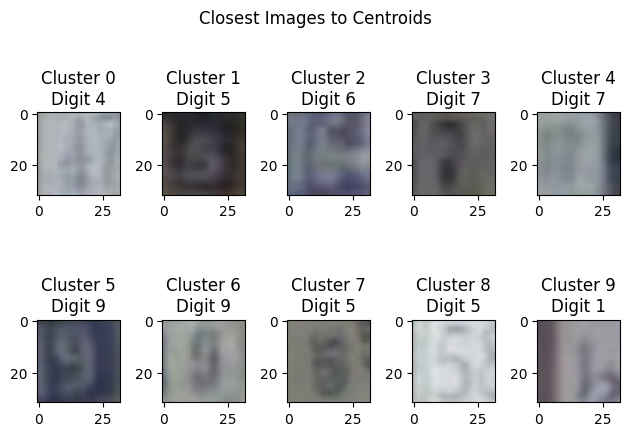

In [11]:
# Perform K-Means on the raw training data
kmeans_10 = KMeans(n_clusters=K, n_init=K)
kmeans_10 = kmeans_10.fit(train_X_gen)

# Iterate over K labels and output which actual classes are grouped together
print("Classes that appear in each k-means cluster")
for i in range(K):
    # Get indices having this K-means label
    idx = np.where(kmeans_10.labels_ == i)[0]
    # Find unique values
    clust_uniq = np.unique(train_Y_gen[idx])
    # Print the cluster and associated digit classes
    print(i, ":", clust_uniq)

# Iterate over K labels and output closest centroid
fig = plt.figure()
for i in range(K):
    # Get centroid of this label
    centroid_i = kmeans_10.cluster_centers_[i]
    # Find the closest point to the label
    closest_pt_idx = (((train_X_gen)-centroid_i[None, :])**2).sum(1).argmin()
    closest_pt_i = train_X_gen[closest_pt_idx]
    # Display closest point along with cluster number and label
    sub = fig.add_subplot(2, 5, i+1)
    sub.imshow(closest_pt_i.reshape(32,32,3))
    sub.set_title('Cluster ' + str(i) + '\nDigit ' + str(train_Y_gen[closest_pt_idx][0]%10))

fig.suptitle('Closest Images to Centroids')
fig.tight_layout()

#### Evaluation Metrics

##### Sum of Squares Error

In [12]:
# Compute sum of squares error, this is done by the kmeans_10.score method itself
-kmeans_10.score(train_X_gen)

80345996828.67268

##### Purity

In [13]:
# Compute purity as fraction of most frequent label in cluster
pur_arr = np.array([])
print("Purity of each cluster")
for i in range(K):
    # Compute digits in the cluster
    digits = train_Y_gen[np.where(kmeans_10.labels_ == i)[0]].ravel()
    # Compute maximum frequency in cluster
    max_freq_i = np.bincount(digits).max()
    # Compute purity of the cluster
    purity = max_freq_i/len(digits)
    pur_arr = np.append(pur_arr, purity)
    print(i, ":", purity)
print("Average purity:", np.mean(pur_arr))

Purity of each cluster
0 : 0.11134542387178406
1 : 0.11469780219780219
2 : 0.11962931760741365
3 : 0.10458856703409382
4 : 0.13907785336356765
5 : 0.12459230267449445
6 : 0.11401502776870304
7 : 0.1083223249669749
8 : 0.11317567567567567
9 : 0.1798631476050831
Average purity: 0.12293074427655926


##### Rand-Index

In [14]:
# Compute rand_score using inbuilt functions
# train_Y_gen is reduced modulo 10 so that the ranges match.
rand_score(kmeans_10.labels_, train_Y_gen.ravel()%10)

0.8076955814232569

#### Classification Accuracy

In [15]:
# Run K-Means on the test dataset
pred_labels = kmeans_10.predict(test_X_reshaped)

# Compute classification accuracy
num_correct = 0
for i in range(K):
    # Compute digits in the cluster
    digits = test_Y_reshaped[np.where(kmeans_10.labels_ == i)[0]].ravel()
    # Compute maximum frequency in cluster
    max_freq_i = np.bincount(digits).max()
    num_correct += max_freq_i
print("Classification accuracy:", num_correct/test_Y_reshaped.shape[0])

Classification accuracy: 0.18830669944683467


### Using 27 Eigenvectors

Classes that appear in each k-means cluster
0 : [ 1  2  3  4  5  6  7  8  9 10]
1 : [ 1  2  3  4  5  6  7  8  9 10]
2 : [ 1  2  3  4  5  6  7  8  9 10]
3 : [ 1  2  3  4  5  6  7  8  9 10]
4 : [ 1  2  3  4  5  6  7  8  9 10]
5 : [ 1  2  3  4  5  6  7  8  9 10]
6 : [ 1  2  3  4  5  6  7  8  9 10]
7 : [ 1  2  3  4  5  6  7  8  9 10]
8 : [ 1  2  3  4  5  6  7  8  9 10]
9 : [ 1  2  3  4  5  6  7  8  9 10]


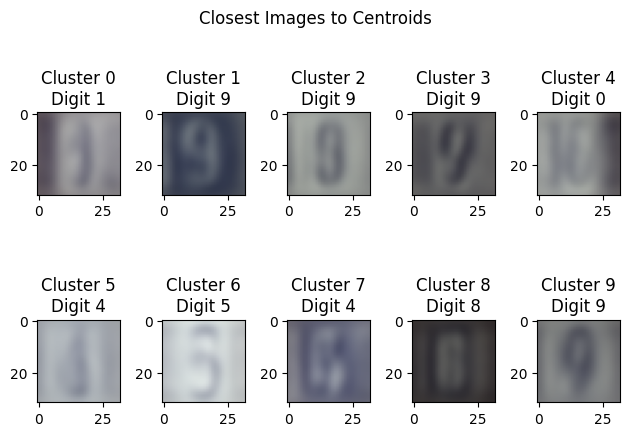

In [16]:
# Perform K-Means on the preprocessed training data
kmeans_10 = kmeans_10.fit(train_X_pca_27)

# Iterate over K labels and output which actual classes are grouped together
print("Classes that appear in each k-means cluster")
for i in range(K):
    # Get indices having this K-means label
    idx = np.where(kmeans_10.labels_ == i)[0]
    # Find unique values
    clust_uniq = np.unique(train_Y_gen[idx])
    # Print the cluster and associated digit classes
    print(i, ":", clust_uniq)

# Iterate over K labels and output closest image to centroid
fig = plt.figure()
for i in range(K):
    # Get centroid of this cluster
    centroid_i = kmeans_10.cluster_centers_[i]
    # Find the closest point to the centroid
    closest_pt_idx = ((train_X_pca_27-centroid_i[None, :])**2).sum(1).argmin()
    closest_pt_i = train_X_pca_27[closest_pt_idx]
    # print(i)
    # print(train_scaler.inverse_transform(np.array([train_X_gen[closest_pt_idx]])).reshape(32,32,3))
    # print(np.asarray(train_scaler.inverse_transform(pca_27.inverse_transform(np.array([closest_pt_i]))).reshape(32,32,3), int))
    # Display closest point along with cluster number and digit
    sub = fig.add_subplot(2, 5, i+1)
    sub.imshow(np.asarray(train_scaler.inverse_transform(pca_27.inverse_transform(np.array([closest_pt_i]))).reshape(32,32,3), int))
    sub.set_title('Cluster ' + str(i) + '\nDigit ' + str(train_Y_gen[closest_pt_idx][0]%10))

fig.suptitle('Closest Images to Centroids')
fig.tight_layout()

#### Evaluation Metrics

##### Sum of Squares Error

In [17]:
-kmeans_10.score(train_X_pca_27)

24089808.57889293

##### Purity

In [18]:
# Compute purity as fraction of most frequent label in cluster
pur_arr = np.array([])
print("Purity of each cluster")
for i in range(K):
    # Compute digits in the cluster
    digits = train_Y_gen[np.where(kmeans_10.labels_ == i)[0]].ravel()
    # Compute maximum frequency in cluster
    max_freq_i = np.bincount(digits).max()
    # Compute purity of the cluster
    purity = max_freq_i/len(digits)
    pur_arr = np.append(pur_arr, purity)
    print(i, ":", purity)
print("Average purity:", np.mean(pur_arr))

Purity of each cluster
0 : 0.17575757575757575
1 : 0.1234248788368336
2 : 0.11264367816091954
3 : 0.1041343669250646
4 : 0.13707865168539327
5 : 0.11181702668360864
6 : 0.11185308848080133
7 : 0.11976301311891663
8 : 0.11364409663150732
9 : 0.10883280757097792
Average purity: 0.12189491838515984


##### Rand-Index

In [19]:
rand_score(kmeans_10.labels_, train_Y_gen.ravel())

0.8076342157686307

#### Classification Accuracy

In [20]:
# Run K-Means on the test dataset
pred_labels = kmeans_10.predict(test_X_pca_27)

# Compute classification accuracy
num_correct = 0
for i in range(K):
    # Compute digits in the cluster
    digits = test_Y_reshaped[np.where(kmeans_10.labels_ == i)[0]].ravel()
    # Compute maximum frequency in cluster
    max_freq_i = np.bincount(digits).max()
    num_correct += max_freq_i
print("Classification accuracy:", num_correct/test_Y_reshaped.shape[0])

Classification accuracy: 0.18830669944683467


### Using 10 Eigenvectors

Classes that appear in each k-means cluster
0 : [ 1  2  3  4  5  6  7  8  9 10]
1 : [ 1  2  3  4  5  6  7  8  9 10]
2 : [ 1  2  3  4  5  6  7  8  9 10]
3 : [ 1  2  3  4  5  6  7  8  9 10]
4 : [ 1  2  3  4  5  6  7  8  9 10]
5 : [ 1  2  3  4  5  6  7  8  9 10]
6 : [ 1  2  3  4  5  6  7  8  9 10]
7 : [ 1  2  3  4  5  6  7  8  9 10]
8 : [ 1  2  3  4  5  6  7  8  9 10]
9 : [ 1  2  3  4  5  6  7  8  9 10]


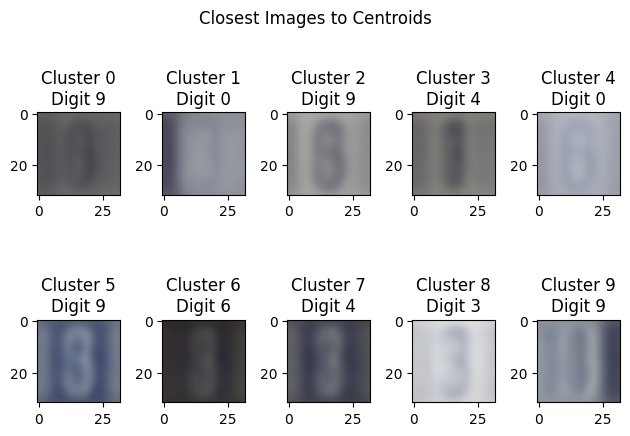

In [21]:
# Perform K-Means on the preprocessed training data
kmeans_10 = kmeans_10.fit(train_X_pca_10)

# Iterate over K labels and output which actual classes are grouped together
print("Classes that appear in each k-means cluster")
for i in range(K):
    # Get indices having this K-means label
    idx = np.where(kmeans_10.labels_ == i)[0]
    # Find unique values
    clust_uniq = np.unique(train_Y_gen[idx])
    # Print the cluster and associated digit classes
    print(i, ":", clust_uniq)

# Iterate over K labels and output closest image to centroid
fig = plt.figure()
for i in range(K):
    # Get centroid of this cluster
    centroid_i = kmeans_10.cluster_centers_[i]
    # Find the closest point to the centroid
    closest_pt_idx = ((train_X_pca_10-centroid_i[None, :])**2).sum(1).argmin()
    closest_pt_i = train_X_pca_10[closest_pt_idx]
    # Display closest point along with cluster number and digit
    sub = fig.add_subplot(2, 5, i+1)
    sub.imshow(np.asarray(train_scaler.inverse_transform(pca_10.inverse_transform(np.array([closest_pt_i]))).reshape(32,32,3), int))
    sub.set_title('Cluster ' + str(i) + '\nDigit ' + str(train_Y_gen[closest_pt_idx][0]%10))

fig.suptitle('Closest Images to Centroids')
fig.tight_layout()

#### Evaluation Metrics

##### Sum of Squares Error

In [22]:
-kmeans_10.score(train_X_pca_10)

17777377.95600933

##### Purity

In [23]:
# Compute purity as fraction of most frequent label in cluster
pur_arr = np.array([])
print("Purity of each cluster")
for i in range(K):
    # Compute digits in the cluster
    digits = train_Y_gen[np.where(kmeans_10.labels_ == i)[0]].ravel()
    # Compute maximum frequency in cluster
    max_freq_i = np.bincount(digits).max()
    # Compute purity of the cluster
    purity = max_freq_i/len(digits)
    pur_arr = np.append(pur_arr, purity)
    print(i, ":", purity)
print("Average purity:", np.mean(pur_arr))

Purity of each cluster
0 : 0.10504090789126419
1 : 0.17407757805108798
2 : 0.10946076848563126
3 : 0.10658965607771069
4 : 0.11239193083573487
5 : 0.1207115628970775
6 : 0.11329201101928375
7 : 0.12524334847501623
8 : 0.11330049261083744
9 : 0.14513556618819776
Average purity: 0.12252438225318416


##### Rand-Index

In [24]:
rand_score(kmeans_10.labels_, train_Y_gen.ravel())

0.8079673106924277

#### Classification Accuracy

In [25]:
# Run K-Means on the test dataset
pred_labels = kmeans_10.predict(test_X_pca_10)

# Compute classification accuracy
num_correct = 0
for i in range(K):
    # Compute digits in the cluster
    digits = test_Y_reshaped[np.where(kmeans_10.labels_ == i)[0]].ravel()
    # Compute maximum frequency in cluster
    max_freq_i = np.bincount(digits).max()
    num_correct += max_freq_i
print("Classification accuracy:", num_correct/test_Y_reshaped.shape[0])

Classification accuracy: 0.18830669944683467


## K-Means and K-NN

We compare the two methods k-means clustering and k-nearest neighbours using
classification accuracy as the common metric. The following observations can be
made.

1. The classification accuracy using kNN is more than twice that when k-means is
   used. This is because multiple digits have fallen into the same cluster while
   performing k-means clustering, leading to very low test accuracy.
2. The dataset consists of images in the same class that can be widely varying
   in terms of L2 norm. This can be because of the colours used for the digits
   and the background. Thus, images that should be in the same cluster can be
   too far apart to be clustered together. Further, images in different classes
   can be in the same cluster in terms of L2 norm, which is the case for our
   training dataset.

## Using a Reduced Number of Clusters

In this section, we assess the effect of using a reduced number of clusters to
perform k-means clustering. Here, we use 5 clusters instead of 10.

In [26]:
# K Means with 5 clusters and PCA with 27 dimensions

K1 = 5
kmeans_5 = KMeans(n_clusters=K1, n_init=K1).fit(train_X_pca_27)

# Iterate over K labels and output which actual classes are grouped together
print("Classes that appear in each k-means cluster")
for i in range(K1):
    # Get indices having this K-means label
    idx = np.where(kmeans_5.labels_ == i)[0]
    # Find unique values
    clust_uniq = np.unique(train_Y_gen[idx])
    # Print the cluster and associated digit classes
    print(i, ":", clust_uniq)

Classes that appear in each k-means cluster
0 : [ 1  2  3  4  5  6  7  8  9 10]
1 : [ 1  2  3  4  5  6  7  8  9 10]
2 : [ 1  2  3  4  5  6  7  8  9 10]
3 : [ 1  2  3  4  5  6  7  8  9 10]
4 : [ 1  2  3  4  5  6  7  8  9 10]
5 : []
6 : []
7 : []
8 : []
9 : []
